In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats

## Since we are on this topic, let's examine the variance of binomial
I know the theoretical variance. Let's just see the empirical variance

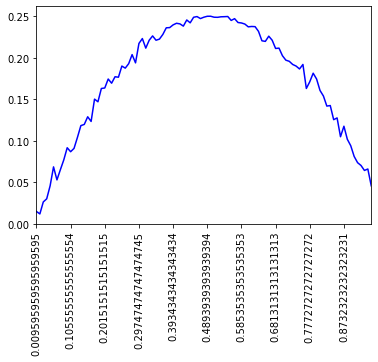

In [2]:
var_list = []

CTR_list2 = np.linspace(0.00,0.95, 100)[1:]

for this_CTR in CTR_list2:
    samples = np.random.binomial(n=1, p=this_CTR, size=1000)
    var_list.append(np.var(samples))

fig, ax = plt.subplots()
ax.plot(var_list, color='blue')

ax.set_xlim((0, len(var_list)-1))
xticks=list(range(0, len(var_list),10))
_ = ax.set_xticks(xticks)
_ = ax.set_xticklabels(CTR_list2[xticks], rotation=90)

# Calculating the variance of click through rate

In [3]:
np.random.seed(0)

CTR = 0.05
def generate_CTR(users=1000, CTR=CTR, avg_page = 4.5):
    users_page = np.random.poisson(avg_page, size=users) + 1
    clicks = np.random.binomial(users_page, CTR)
    return users_page, clicks

# 10000 rows (of samples), each row 1000 users
users_page, clicks = generate_CTR(users=(10000,1000))
clicks.shape

(10000, 1000)

In [4]:
# CTR1
# click-through rate = total clicks / total page views
ctr1 = np.sum(clicks, axis=1)*1.0 / np.sum(users_page, axis=1)
display(ctr1.shape)
ctr1[:10]

(10000,)

array([0.04936686, 0.04496908, 0.05069897, 0.05401987, 0.05201342,
       0.04958829, 0.05156366, 0.05345572, 0.05018956, 0.05117039])

8.718014549768185e-06

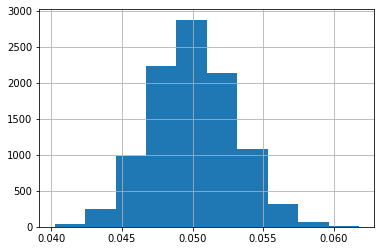

In [5]:
display(np.var(ctr1))
pd.Series(ctr1).hist()

## using a different definition, we have different variance

(10000,)

1.059973122964953e-05

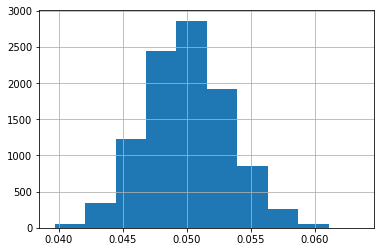

In [6]:
# CT2
# average each user's CTR
ctr2 = np.mean(clicks *1.0 / users_page, axis=1)
display(ctr2.shape)
display(np.var(ctr2))
pd.Series(ctr2).hist()

In [7]:
ctr2[:10]

array([0.04926526, 0.04297006, 0.05164805, 0.05378173, 0.05035891,
       0.05087899, 0.05202202, 0.05477003, 0.05221314, 0.05315665])

If I want to replicate the wrong calculation of variance in the book, I need to keep track of the number of clicks by each page. 

## Let's how the variance change according to the CTR

In [8]:
def generate_CTR(users=1000, CTR=0.3, avg_page = 4.5):
    users_page = np.random.poisson(avg_page, size=users) + 1
    clicks = np.random.binomial(users_page, CTR)
    
    ctr1 = np.sum(clicks, axis=1)*1.0 / np.sum(users_page, axis=1)
    ctr2 = np.mean(clicks *1.0 / users_page, axis=1)
    return np.var(ctr1), np.var(ctr2)
CTR_list = np.linspace(0.00,0.5, 20)[1:]
CTR_list[:5]

array([0.02631579, 0.05263158, 0.07894737, 0.10526316, 0.13157895])

In [9]:
res = []
for this_ctr in CTR_list:
    res.append(list(generate_CTR(users=(10000,1000),CTR=this_ctr)))

In [10]:
res_np = np.array(res)
res_np.shape

(19, 2)

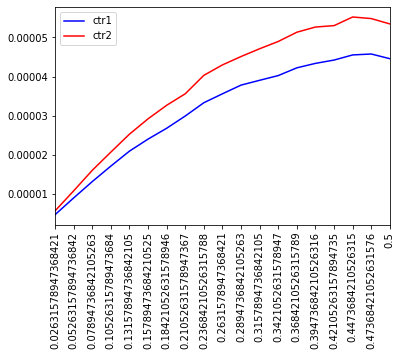

In [11]:
%precision %.2f
fig, ax = plt.subplots()
ax.plot(res_np[:, 0], label='ctr1',color='blue')
ax.plot(res_np[:, 1], label='ctr2',color='red')
ax.set_xlim((0, len(res_np)-1))
xticks=range(0, len(res_np))
_ = ax.set_xticks(xticks)
_ = ax.set_xticklabels(CTR_list, rotation=90)
ax.legend()

### The wrong way to calculate variance in CTR1
basically:
$$Var(X) = E[(X-E(X))^2]$$

if we treat $CTR_1$ as $E(X)$, we should further divide it by N:
$$VAR(CTR_1) = \frac{\Sigma_{i=1}^n \Sigma_{j=1}^{K_j} (X_{ij} - CTR_1)^2}{N^2}$$

because I do not keep track of $X_{ij}$, I have to do it differently.

For each user $i$, we have $X_{ij}$ is either 0 or 1,so:
$$\Sigma_{j=1}^{K_j} (X_{ij} - CTR_1)^2$$
$$=NumClicks(1-CTR_1)^2 + (NumPage - NumClicks)CTR_1^2$$

I then have to divide everything by the number of observations, ie users_page
applying this:

In [12]:
ctr1_broadcast = np.broadcast_to(ctr1, (1000, ctr1.shape[0])).T
display(ctr1)
display(ctr1_broadcast[:5, :5])

array([0.04936686, 0.04496908, 0.05069897, ..., 0.05211726, 0.05531295,
       0.04825443])

array([[0.04936686, 0.04936686, 0.04936686, 0.04936686, 0.04936686],
       [0.04496908, 0.04496908, 0.04496908, 0.04496908, 0.04496908],
       [0.05069897, 0.05069897, 0.05069897, 0.05069897, 0.05069897],
       [0.05401987, 0.05401987, 0.05401987, 0.05401987, 0.05401987],
       [0.05201342, 0.05201342, 0.05201342, 0.05201342, 0.05201342]])

In [13]:
display(clicks.shape, users_page.shape, ctr1_broadcast.shape)

(10000, 1000)

(10000, 1000)

(10000, 1000)

In [14]:
np.sum(users_page, axis=1)

array([5449, 5337, 5365, ..., 5526, 5496, 5471])

In [15]:
#square_term = clicks * (1- ctr1_broadcast)**2 
#square_term = square_term + (users_page - clicks)*ctr1_broadcast**2
square_term = clicks * (1- CTR)**2 
square_term = square_term + (users_page - clicks)*CTR**2

var_term = np.sum(square_term, axis=1) / np.sum(users_page, axis=1)**2
display(var_term.shape)
var_term[:10]

(10000,)

array([8.61262079e-06, 8.05174731e-06, 8.97093706e-06, 9.23539046e-06,
       9.19315446e-06, 8.62387195e-06, 9.10411338e-06, 9.10909849e-06,
       8.60635646e-06, 8.81026091e-06])

8.644154514785802e-06

2.44716755897538e-13

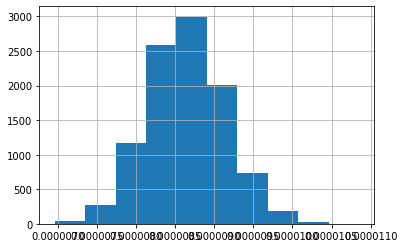

In [16]:
var_term = pd.Series(var_term)
display(var_term.hist())
display(var_term.mean(), var_term.var())

In [17]:
np.var(ctr1) / var_term.mean()

1.0085445065629086

so nothing's wrong?

According to the book, this leads to $CTR_1$ was satistically significant far more often than the expected 5%. Is it true? I think <b>the problem</b> is that I use the same CTR throughout. suppose I use a different CTR for each user, the variance will be different.

Let's look at the simulation

## Using the right variance, p-value is Uniformly distributed

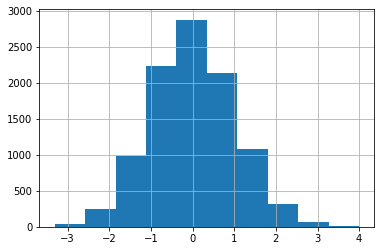

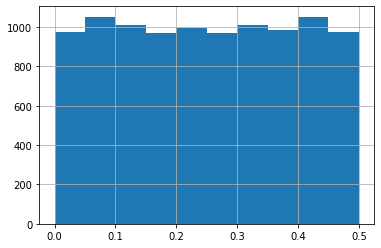

In [18]:
t_stat = (ctr1 - CTR)/np.std(ctr1)
pval = stats.t.sf(abs(t_stat), 1000-1)
display(pd.Series(t_stat).hist())
plt.show()
display(pd.Series(pval).hist())

### What if I use a wrong, smaller variance
p value is significant much more than before

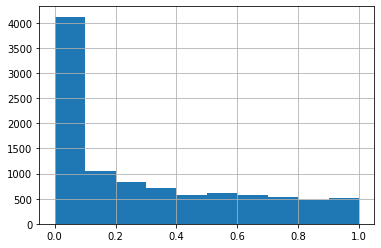

In [19]:
t_stat2 = (ctr1 - CTR)/np.std(ctr1) * 2
pval2 = stats.t.sf(abs(t_stat2), 1000-1) * 2
display(pd.Series(pval2).hist())

### What if I use a wrong, larger variance

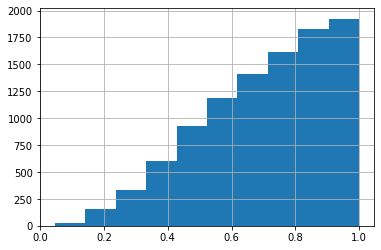

In [20]:
t_stat2 = (ctr1 - CTR)/np.std(ctr1) / 2
pval2 = stats.t.sf(abs(t_stat2), 1000-1) * 2
display(pd.Series(pval2).hist())

## so if we have t values without the variance, we can calculate the variance so that p-value's distribution is as close to uniform as possible

## Using the wrong variance, p-value is not normally distributed

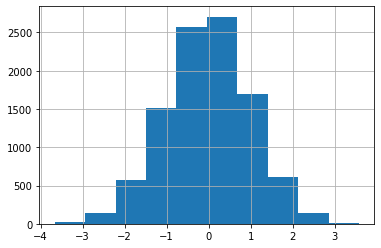

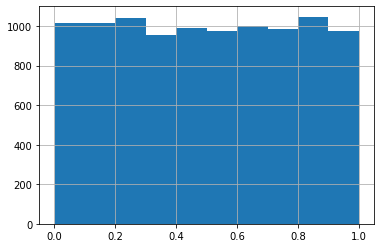

In [21]:
# https://stackoverflow.com/questions/17559897/python-p-value-from-t-statistic
t_stat = (ctr1 - CTR)/np.sqrt(var_term)
pval = stats.t.sf(abs(t_stat), 1000-1) * 2
display(pd.Series(t_stat).hist())
plt.show()
display(pd.Series(pval).hist())

According to the book, this leads to $CTR_1$ was satistically significant far more often than the expected 5%. Is it true? I think my simulation leads to a different answer.

My hypothesis is that I use the same CTR for all users. If I change the CTR across users, I will see something different.

# Use a Beta distribution for the value of click through rate for each user

Source: https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html

This has to do with the way to pick $\alpha$ and $\beta$. The beta distribution can be specified by:

- Shape: $\alpha$ and $\beta$
- Mean (based on $\alpha$ and $\beta$) and sample size(proxy for variance) $v = \alpha + \beta$

The article suggests the 2nd approach:

- $\phi$: related to the expected performance for all players -> uniform
- $\kappa$: the variance of batting average -> Pareto distribution. However, it is more efficient to pick the log of $\kappa$ as an exponential distribution , which has large tail

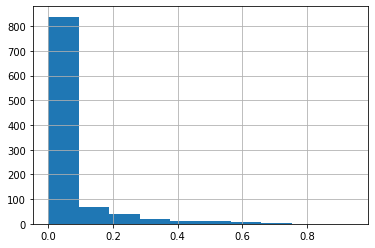

In [22]:
phi = 0.05
kappa_log = 1
kappa = np.exp(kappa_log)
alpha= phi * kappa
beta=(1.0 - phi) * kappa

num_users = 1000
num_sims = 10000
users_ctr = np.random.beta(a=alpha, b=beta, size=num_users)
pd.Series(users_ctr).hist()


In [23]:
users_ctr.shape

(1000,)

In [24]:
users = (num_sims , num_users)
avg_page = 5.5
users_page = np.random.poisson(avg_page, size=users) + 1
clicks = np.random.binomial(users_page, users_ctr)
display(users_page.shape, clicks.shape)

(10000, 1000)

(10000, 1000)

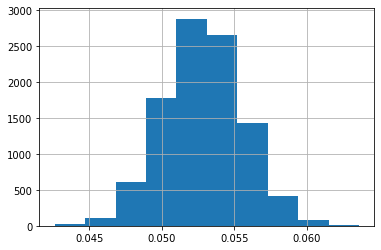

In [25]:
ctr1 = np.sum(clicks, axis=1)*1.0 / np.sum(users_page, axis=1)
ctr1_broadcast = np.broadcast_to(ctr1, (num_users, num_sims)).T

pd.Series(ctr1).hist()

In [26]:
square_term = clicks * (1- ctr1_broadcast)**2 
square_term = square_term + (users_page - clicks)*ctr1_broadcast**2
var_term = np.sum(square_term, axis=1) / np.sum(users_page, axis=1)**2

display(var_term.shape)
var_term[:10]

(10000,)

array([6.96391325e-06, 7.17990912e-06, 7.75392042e-06, 7.27931363e-06,
       7.92526824e-06, 7.78957381e-06, 7.49581577e-06, 7.80258246e-06,
       7.07588924e-06, 8.00700151e-06])

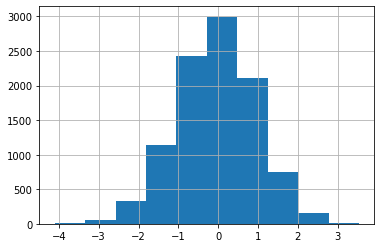

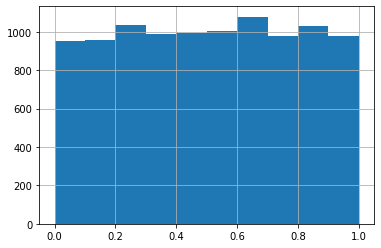

In [27]:
t_stat = (ctr1 - np.mean(users_ctr))/np.sqrt(var_term)
pval = stats.t.sf(abs(t_stat), 1000-1) * 2
display(pd.Series(t_stat).hist())
plt.show()
display(pd.Series(pval).hist())

Now we can see some issues, but it is not in the direction that I was expecting